In [1]:
import numpy as np
import pandas as pd
import os
from scipy import io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("husl", 5)

min_max_scaler = preprocessing.MinMaxScaler()

In [2]:
mat_file = io.loadmat('Dataset/Electric_Vehicle_data/route1.mat')

In [3]:
mat_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ACCEL', 'CURRENT', 'PEDAL', 'SPEED', 'Time', 'VOLTAGE'])

In [4]:
mat_file['Time'].squeeze()

array([0.00000000e+00, 6.66666667e-02, 1.33333333e-01, ...,
       2.06346667e+03, 2.06353333e+03, 2.06360000e+03])

In [5]:
df_data = {}
for key in mat_file.keys():
    if not "__" in key:
        df_data[key] = mat_file[key].squeeze()

df = pd.DataFrame(df_data)
df = df.ffill().bfill()
df.index = df['Time']
df = df.drop('Time', axis=1)

In [6]:
label = df.columns.to_numpy()

In [7]:
label

array(['ACCEL', 'CURRENT', 'PEDAL', 'SPEED', 'VOLTAGE'], dtype=object)

- Dataset per 50ms 
- 4 datapoint equals to 0.2 sec

In [8]:
df.head()

,ACCEL,CURRENT,PEDAL,SPEED,VOLTAGE
Time,,,,,
0.000000,0.0,-1.2,0.0,0.0,80.404831
0.066667,0.0,-1.2,0.0,0.0,80.403419
0.133333,0.0,-1.2,0.0,0.0,80.402008
0.200000,0.0,-1.2,0.0,0.0,80.400597
0.266667,0.0,-1.2,0.0,0.0,80.399185


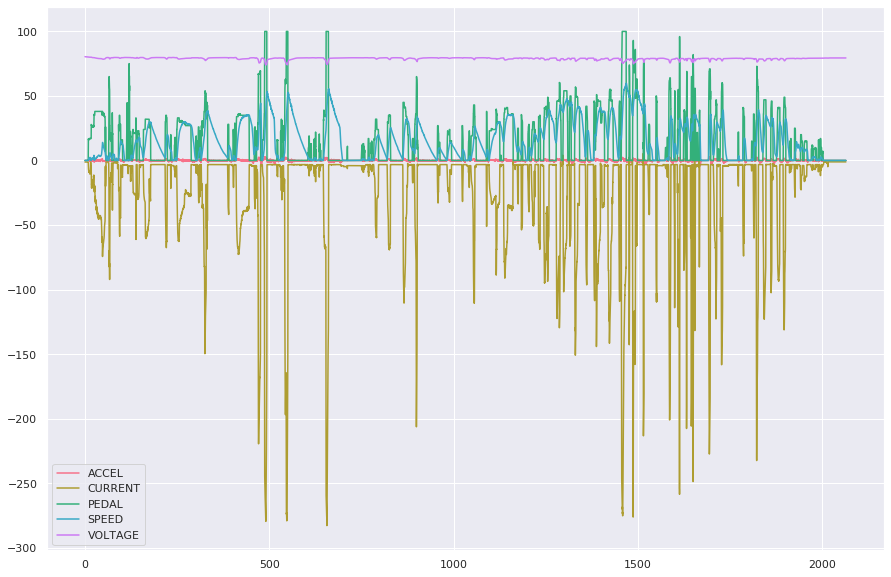

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(df)
plt.legend(label)

In [10]:
data = min_max_scaler.fit_transform(df)

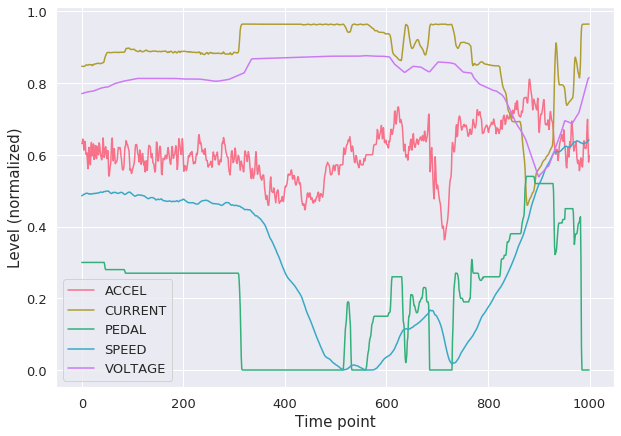

In [35]:
plt.figure(figsize=(10,7))
plt.xlabel('Time point', fontsize=15)
plt.ylabel('Level (normalized)', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.plot(data[4000:5000])
plt.legend(label, fontsize=13)

## Sliding window
- target prediction range: 10 sec
- before range: 10 sec
- 20 point = 1 sec
- before take: 200 time point
- prediction range: 10 second (per sec: take per 20 time points)

In [12]:
data.shape

(30955, 5)

In [13]:
import math

def dataToNumpy(data, look_back, horizon_length, stride):
    total_data_size = math.trunc((data.shape[0]-look_back-horizon_length+1)/stride)
    print(total_data_size)
    features = np.zeros((total_data_size, look_back, 5))
    labels = np.zeros((total_data_size, 10))
    j=0
    while (j+look_back+horizon_length)<data.shape[0]:
        feature = np.array(data[j:(j+look_back)])
        label = np.array(data[(j+look_back):(j+look_back+horizon_length), 3]).squeeze()
        label = label[::-20]
        label = np.flip(label)
#         label = np.array(data[j+look_back+horizon_length, 3]).squeeze()
#         label = np.digitize(label, bins = np.array([0, 0.25, 0.5, 0.75]), right=True)
        features[int(j/stride)] = feature
        labels[int(j/stride)] = label
        j+=stride
    return features, labels

In [14]:
X, y = dataToNumpy(data, 200, 200, 1)

30556


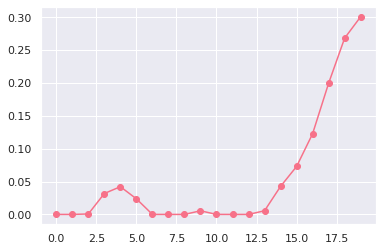

In [15]:
idx =11478
plt.plot(np.concatenate((X[idx,:,3][::20], y[idx])), '-o')

In [16]:
X[idx,:,3][::20]

array([0.00000000e+00, 0.00000000e+00, 6.93477369e-04, 3.18171626e-02,
       4.21835076e-02, 2.37439772e-02, 3.63652603e-05, 0.00000000e+00,
       6.22428320e-06, 5.51146922e-03])

In [17]:
y.shape

(30556, 10)

## Process overall

In [18]:
def get_df(path):
    mat_file = io.loadmat(path)
    df_data = {}
    for key in mat_file.keys():
        if not "__" in key:
            df_data[key] = mat_file[key].squeeze()

    df = pd.DataFrame(df_data)
    df = df.ffill().bfill()
    df.index = df['Time']
    df = df.drop('Time', axis=1)
    
    label = df.columns.to_numpy()
    
    return df, label

In [19]:
df_list = []
label_list = []

for path in os.listdir('Dataset/Electric_Vehicle_data/'):
    if not '._' in path and '.mat' in path:
        df, label = get_df(os.path.join('Dataset/Electric_Vehicle_data/', path))
        df_list.append(df)
        label_list.append(label)

## Fit normalizer to total data

In [20]:
for idx, df in enumerate(df_list):
    if idx == 0:
        full_df = df
    else:
        full_df = full_df.append(df)

In [21]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(full_df)
pickle.dump(min_max_scaler, open('scaler.pkl', 'wb'))

In [22]:
full_df['SPEED'].min()

0.0

In [23]:
for idx, df in enumerate(df_list):
    if idx == 0:
        X, y = dataToNumpy(min_max_scaler.transform(df), 200, 200, 1)
    elif idx == 1:
        X_test, y_test = min_max_scaler.transform(df), min_max_scaler.transform(df)[:,3]
    else:
        tmp1, tmp2 = dataToNumpy(min_max_scaler.transform(df), 200, 200, 1)
        X, y = np.concatenate((X, tmp1), axis=0), np.concatenate((y, tmp2), axis=0)

24183
30556
27819
62166


In [24]:
full_df['SPEED'].max()

62.67900607155796

## Make Dataset

In [25]:
X = X.transpose(0,2,1)

pickle.dump(X, open('Data/regression/X_train.pkl', 'wb'))
pickle.dump(y, open('Data/regression/y_train.pkl', 'wb'))
pickle.dump(X_test, open('Data/regression/X_test.pkl', 'wb'))
pickle.dump(y_test, open('Data/regression/y_test.pkl', 'wb'))

## Dataset Batch loader
- Let Batchsize = 100

In [26]:
# import torch
# from torch import nn, optim
# from torch.utils.data import TensorDataset, DataLoader

In [27]:
# X = torch.tensor(X, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.float32)

# ds = TensorDataset(X, y)

In [28]:
# for X, y in loader:
#     print(X.shape, y.shape)
#     break